In [1]:
import warnings
warnings.simplefilter('ignore')

import os
import gym
import random
from collections import deque
from matplotlib import pyplot as plt
import numpy as np

import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

import tensorflow.keras as k
from tensorflow.keras.layers import Dense, Input, Concatenate
from tensorflow.keras.optimizers import Adam

print("Is GPU available?", tf.config.list_physical_devices('GPU'))
print("TF version:", tf.__version__)
print("Keras version:", tf.keras.__version__)

Is GPU available? [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TF version: 2.3.0
Keras version: 2.4.0


In [2]:
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)

In [3]:
def actor(num_states):
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)
    
    inputs = Input(shape=(num_states,))
    out = Dense(256, activation='relu')(inputs)
    out = Dense(256, activation='relu')(out)
    outputs = Dense(1, activation='tanh', kernel_initializer=last_init)(out)
    
    outputs = outputs * upper_bound
    model = tf.keras.Model(inputs, outputs)
    return model

In [4]:
def critic(num_states, num_actions):
    state_input = Input(shape=(num_states))
    state_out = Dense(16, activation='relu')(state_input)
    state_out = Dense(32, activation='relu')(state_out)
    
    action_input = Input(shape=(num_actions))
    action_out = Dense(32, activation='relu')(action_input)
    
    concat = Concatenate()([state_out, action_out])
    
    out = Dense(256, activation='relu')(concat)
    out = Dense(256, activation='relu')(out)
    outputs = Dense(1)(out)
    
    model = tf.keras.Model([state_input, action_input], outputs)
    
    return model

In [5]:
class Agent():
    def __init__(self, max_mem, batch_size, gamma, tau, input_shape, n_actions):
        self.memory = deque(maxlen=max_mem)
        self.batch_size = batch_size
        self.gamma = gamma
        self.tau = tau
        self.ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(0.2) * np.ones(1))
        self.actor_model = actor(input_shape)
        self.critic_model = critic(input_shape, n_actions)
        self.target_actor = actor(input_shape)
        self.target_critic = critic(input_shape, n_actions)
        
        self.actor_optimizer = Adam(lr=0.002)
        self.critic_optimizer = Adam(lr=0.001)
        
        self.target_actor.set_weights(self.actor_model.get_weights())
        self.target_critic.set_weights(self.critic_model.get_weights())

    def store(self, state, action, reward, n_state):
        pack = [np.expand_dims(state, axis=0), action, reward, np.expand_dims(n_state, axis=0)]
        self.memory.append(pack)
    
    def take_data(self):
        pack = random.sample(self.memory, self.batch_size)
        states = []
        actions = []
        rewards = []
        n_states = []
        for i in range(batch_size):
            states.append(pack[i][0])
            actions.append(pack[i][1])
            rewards.append(pack[i][2])
            n_states.append(pack[i][3])
        
        states = tf.convert_to_tensor(states)
        actions = tf.convert_to_tensor(actions)
        rewards = tf.convert_to_tensor(rewards)
        rewards = tf.cast(rewards, dtype=tf.float32)
        n_states = tf.convert_to_tensor(n_states)
        
        return states, actions, rewards, n_states
    
    def choose_action(self, state, noise_obj):
        sampled_actions = tf.squeeze(self.actor_model(state))
        noise = noise_obj()
        sampled_actions = sampled_actions.numpy() + noise
        legal_action = np.clip(sampled_actions, lower_bound, upper_bound)
        
        return [np.squeeze(legal_action)]
    
    @tf.function
    def update_weights(self, target_weights, weights):
        for (a, b) in zip(target_weights, weights):
            a.assign(b * self.tau + a * (1 - self.tau))
    
    @tf.function
    def upgrade(self):
        if len(self.memory) > self.batch_size:
            
            print('Ok')
            states, actions, rewards, n_states = self.take_data()
            
            with tf.GradientTape() as tape:
                target_actions = self.target_actor(n_states, training=True)
                y = rewards + self.gamma*self.target_critic([n_states, target_actions], training=True)
                critic_value = self.critic_model([states, actions], training=True)
                critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))
            
            critic_grad = tape.gradient(critic_loss, self.critic_model.trainable_variables)
            self.critic_optimizer.apply_gradients(zip(critic_grad, self.critic_model.trainable_variables))
            
            with tf.GradientTape() as tape:
                acts = self.actor_model(states, trainig=True)
                critic_value = self.critic_model([states, acts], training=True)
                actor_loss = -tf.math.reduce_mean(critic_value)
            
            actor_grad = tape.gradient(actor_loss, self.actor_model.trainable_variables)
            self.actor_optimizer.apply_gradients(zip(actor_grad, self.actor_model.trainable_variables))
            

In [6]:
env = gym.make('Pendulum-v0')

upper_bound = env.action_space.high[0]
lower_bound = env.action_space.low[0]

agent = Agent(max_mem=50000, batch_size=64, gamma=0.99, tau=0.005,
              input_shape=env.observation_space.shape[0], n_actions=env.action_space.shape[0])

n_games = 250
scores = []
avgs = []

for i in range(n_games):
    state = env.reset()
    score = 0
    done = False
    
    while not done:
        state = tf.expand_dims(tf.convert_to_tensor(state), 0)
        
        action = agent.choose_action(state, agent.ou_noise)
        
        state_, reward, done, _ = env.step(action)
        
        agent.store(state, action, reward, state_)
        
        score += reward
        
        agent.upgrade()
        
        agent.update_weights(agent.target_actor.variables, agent.actor_model.variables)
        agent.update_weights(agent.target_critic.variables, agent.critic_model.variables)
        
        state = state_
    
    scores.append(score)
    avg = np.mean(scores[-100:])
    avgs.append(avg)
    print('Episode', i, 'Avg =', avg)

agent.actor_model.save_weights("actor.h5")
agent.critic_model.save_weights("critic.h5")
agent.target_actor.save_weights("target_actor.h5")
agent.target_critic.save_weights("target_critic.h5")

Episode 0 Avg = -1071.841649379296
Episode 1 Avg = -1285.294774644312
Episode 2 Avg = -1244.4562581845855
Episode 3 Avg = -1281.586549374972
Episode 4 Avg = -1197.118568445438
Episode 5 Avg = -1136.9251928436154
Episode 6 Avg = -1214.2355607334007
Episode 7 Avg = -1281.3017184368948
Episode 8 Avg = -1250.3368922324464
Episode 9 Avg = -1235.1203831166563
Episode 10 Avg = -1222.1264527751023
Episode 11 Avg = -1209.90638733299
Episode 12 Avg = -1255.9626896938262
Episode 13 Avg = -1275.069059189617
Episode 14 Avg = -1253.3269136530723
Episode 15 Avg = -1231.049629159253
Episode 16 Avg = -1206.078333067279
Episode 17 Avg = -1212.6625502497518
Episode 18 Avg = -1225.039481235781
Episode 19 Avg = -1219.2096230341504
Episode 20 Avg = -1215.1533989217105
Episode 21 Avg = -1219.5994112371175
Episode 22 Avg = -1213.039721272858
Episode 23 Avg = -1220.0585839993057
Episode 24 Avg = -1231.7562988430964
Episode 25 Avg = -1221.9875606316944
Episode 26 Avg = -1212.4209983830917
Episode 27 Avg = -1227

Episode 220 Avg = -1305.2878078759868
Episode 221 Avg = -1304.6618257327414
Episode 222 Avg = -1306.0327438206937
Episode 223 Avg = -1311.8877359713315
Episode 224 Avg = -1307.6440552397441
Episode 225 Avg = -1310.4367578777542
Episode 226 Avg = -1313.2242000979843
Episode 227 Avg = -1315.018544934389
Episode 228 Avg = -1320.6938938979622
Episode 229 Avg = -1315.0242708867088
Episode 230 Avg = -1319.2338143865254
Episode 231 Avg = -1314.1445275859057
Episode 232 Avg = -1317.6508445686454
Episode 233 Avg = -1321.4048285771357
Episode 234 Avg = -1324.1768897420736
Episode 235 Avg = -1325.5403025864653
Episode 236 Avg = -1327.3175147081192
Episode 237 Avg = -1322.7832442760694
Episode 238 Avg = -1322.4279216408554
Episode 239 Avg = -1327.7035257225984
Episode 240 Avg = -1331.4855051606146
Episode 241 Avg = -1332.2237855094675
Episode 242 Avg = -1334.428470574409
Episode 243 Avg = -1330.8742503199483
Episode 244 Avg = -1324.2282728521106
Episode 245 Avg = -1317.3390324698878
Episode 246 Av

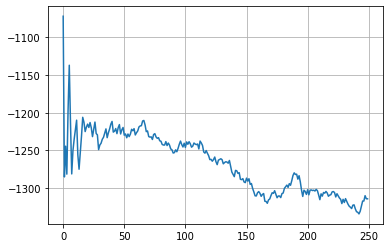

In [7]:
plt.plot(avgs)
plt.grid()
plt.show()